In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

import OurMethod
import torch
import mctorch.nn as mnn
import mctorch.optim as moptim

In [2]:
# define the dataset.

def getX(n):
    nums = []
    for i in range(n):
        x = np.random.random()
        xp = -4+8*x #-1 + 2*x #get data on [-1,1].
        nums += [xp]

    return nums

def getY(n, noise = 0.1):
    nums = []
    for i in range(n):
        noise2 = np.random.random()
        noise2 = -1 + 2*noise2
        y = noise*noise2
        nums += [y]

    return nums

size = 2000
xs = getX(size)
ys = getY(size, noise=0.1)
Xt = np.array([xs,ys])
X = Xt.transpose()

In [3]:
X.shape

(2000, 2)

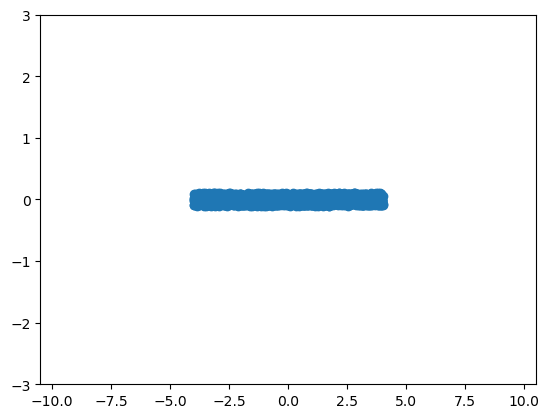

In [4]:
plt.scatter(Xt[0],Xt[1])
plt.xlim((-10.5,10.5))
plt.ylim((-3,3))
plt.show()

In [5]:
def F(p):
    term = 2*p[0]**4 -2*p[0]**2*p[1]**2 + p[1]**4
    return term

In [6]:
labels = [F(p) for p in X]

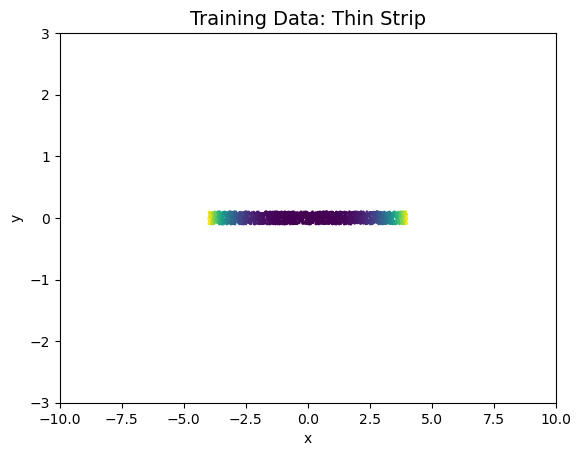

In [227]:
plt.scatter(Xt[0],Xt[1], c=labels, s=1.0)
plt.xlim((-10,10))
plt.ylim((-3,3))

plt.title("Training Data: Thin Strip", fontdict={"fontsize":14})
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("TrainingStrip2.pdf")
plt.show()

In [8]:
poly1 = PolynomialFeatures(4)

In [9]:
B = poly1.fit_transform(X)

In [10]:
BtB = B.transpose()@B

In [11]:
BtBin = np.linalg.inv(BtB)

In [12]:
sol = BtBin@B.transpose()@np.array(labels)

In [13]:
sol

array([ 1.57039937e-11,  1.05249143e-13, -8.97557584e-11, -1.37470590e-12,
       -2.15294449e-12, -7.25071914e-09, -1.53210777e-14,  2.85549362e-13,
        2.56932253e-11,  1.48975232e-08,  2.00000000e+00,  2.41251463e-13,
       -2.00000000e+00, -2.49201548e-10,  1.00000050e+00])

In [217]:
t1 = OurMethod.regress(B, labels, n_epochs=100000, lr=0.0001)

In [218]:
t1

(0.0159086175262928,
 Parameter containing:
 Parameter(Parameter([-2.7793e-03,  2.3035e-03, -7.8724e-01, -2.1953e-03,  2.2454e+00,
             4.2938e-01, -1.0396e-04,  5.4563e-02, -5.1317e-01,  4.2636e-02,
             1.9999e+00, -1.9500e-01, -9.5962e-01,  8.8884e-01,  1.7187e+00],
           requires_grad=True)))

In [17]:
# Not enough "noise." Let's try to impose symmetry.

In [27]:
poly1.get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
       'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3',
       'x1^4'], dtype=object)

In [28]:
# These are the derivatives of the polynomial components.

gradX = np.array([[0.0,1.0,0.0,2*p[0],p[1],0.0,3*p[0]**2,2*p[0]*p[1],p[1]**2,0.0,4*p[0]**3,3*p[0]**2*p[1],2*p[0]*p[1]**2,p[1]**3,0.0] for p in X])
gradY = np.array([[0.0,0.0,1.0,0.0,p[0],2*p[1],0.0,p[0]**2,2*p[0]*p[1],3*p[1]**2,0.0,p[0]**3,2*p[0]**2*p[1],3*p[0]*p[1]**2,4*p[1]**3] for p in X])

In [29]:
Vx = np.array([(X[i][0]**2*X[i][1]-X[i][1]**3)*gradX[i] for i in range(X.shape[0])])
Vy = np.array([(2*X[i][0]**3-X[i][0]*X[i][1]**2)*gradY[i] for i in range(X.shape[0])])

In [30]:
bigV = np.array([Vx,Vy])
bigV.shape

(2, 2000, 15)

In [173]:
def regressSymmetry(B, y, bigV, criterion=torch.nn.MSELoss(), optimizer=moptim.rSGD, lr=1e-2, n_epochs=5000):
    manifold_param = mnn.Parameter(manifold=mnn.Euclidean(B.shape[1]))
    Btensor = torch.tensor(B).float()
    Vtensor = torch.sum(torch.tensor(bigV).float(),0)
    
    
    def model(mat):
        term1 = torch.matmul(Btensor, mat.float())
        return term1
    

    def symmetryModel(mat):
        term = torch.matmul(Vtensor, mat.float()) #term1 + term2
        return term
    
    
    y = torch.tensor(y).float()
    ysym = torch.zeros(Vtensor.shape[0])
    
    optimizer = optimizer(params = [manifold_param], lr=lr)
    for epoch in range(n_epochs):
        y_pred = model(manifold_param)
        ysym_pred = symmetryModel(manifold_param)
        loss = criterion(y_pred, y) + criterion(ysym_pred,ysym)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), manifold_param

In [207]:
t2 = regressSymmetry(B, labels, bigV, criterion=torch.nn.MSELoss(), optimizer=moptim.rAdagrad, lr=1e-0, n_epochs=100000)

In [208]:
t2

(1.4489269233308733e-06,
 Parameter containing:
 Parameter(Parameter([ 1.2761e-04,  1.5120e-07,  2.4603e-06, -7.6397e-05, -1.3464e-06,
             4.2709e-04,  5.5535e-08, -2.6417e-07, -9.7482e-07,  1.8501e-05,
             2.0000e+00,  1.0394e-07, -2.0000e+00,  4.0627e-05,  9.5940e-01],
           requires_grad=True)))

In [209]:
poly1.get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
       'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3',
       'x1^4'], dtype=object)

In [219]:
nosym = OurMethod.invf(np.array(t1[1].detach()),poly1,X)

In [211]:
sym = OurMethod.invf(np.array(t2[1].detach()),poly1,X)

In [220]:
predsNoSym = nosym.f(X)
predsNoSym

array([ 26.72413257, 344.32319486, 250.90168865, ...,  43.25402849,
        77.84229377, 148.05425553])

In [213]:
predsSym = sym.f(X)
predsSym

array([ 26.88796771, 344.38058919, 250.92736048, ...,  43.00309505,
        77.50069327, 148.09458884])

In [201]:
'''plt.scatter(Xt[0],Xt[1], c=labels, s=1.0)
plt.xlim((-10.5,10.5))
plt.ylim((-2,4))
plt.show()'''

'plt.scatter(Xt[0],Xt[1], c=labels, s=1.0)\nplt.xlim((-10.5,10.5))\nplt.ylim((-2,4))\nplt.show()'

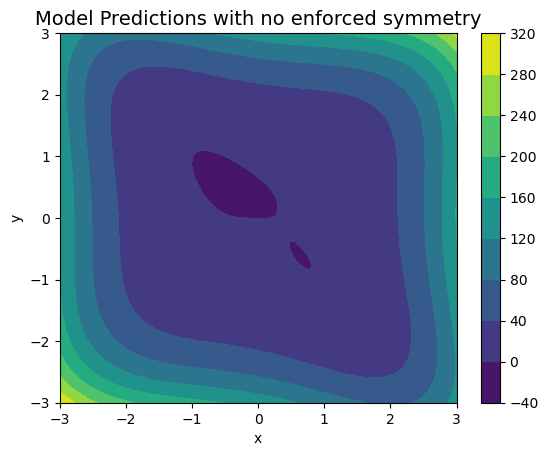

In [226]:
xs = np.linspace(-3,3,600)
ys = np.linspace(-3,3,600)
Xs, Ys = np.meshgrid(xs, ys)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
#grid = np.array([grid[0],grid[1],[1 for i in range(grid.shape[1])]])
gridProbs = nosym.f(grid.transpose())
#plt.scatter(grid[0], grid[1], c=gridProbs)
zz = gridProbs.reshape(600,600)
h = plt.contourf(xs, ys, zz)#, levels=[5*(i-1) for i in range(7)])
#plt.axis('scaled')
plt.colorbar()

plt.title("Model Predictions with no enforced symmetry", fontdict={"fontsize":14})
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("nosym2.pdf")
#plt.savefig("svmdist.pdf")
#plt.show()

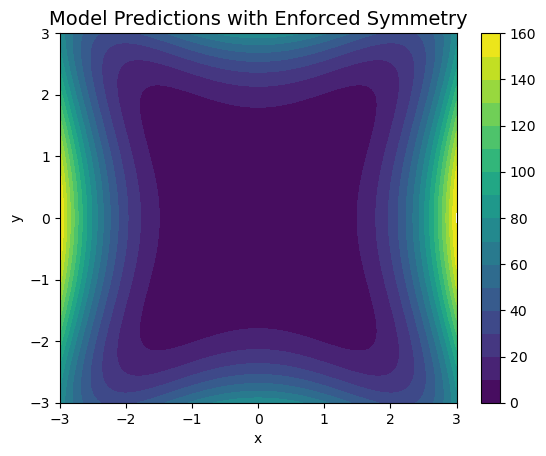

In [228]:
xs = np.linspace(-3,3,1200)
ys = np.linspace(-3,3,1200)
Xs, Ys = np.meshgrid(xs, ys)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
#grid = np.array([grid[0],grid[1],[1 for i in range(grid.shape[1])]])
gridProbs = sym.f(grid.transpose())
#plt.scatter(grid[0], grid[1], c=gridProbs)
zz = gridProbs.reshape(1200,1200)
h = plt.contourf(xs, ys, zz, levels=[10*(i-0) for i in range(17)])
#plt.axis('scaled')
plt.colorbar()

plt.title("Model Predictions with Enforced Symmetry", fontdict={"fontsize":14})
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("sym2.pdf")
#plt.savefig("svmdist.pdf")
#plt.show()

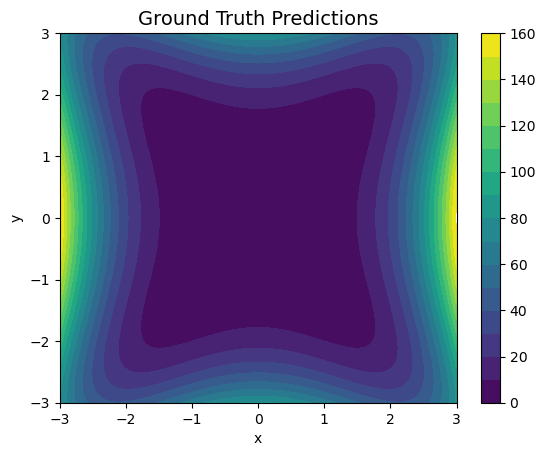

In [229]:
xs = np.linspace(-3,3,600)
ys = np.linspace(-3,3,600)
Xs, Ys = np.meshgrid(xs, ys)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
#grid = np.array([grid[0],grid[1],[1 for i in range(grid.shape[1])]])
gridProbs = F(grid)
#plt.scatter(grid[0], grid[1], c=gridProbs)
zz = gridProbs.reshape(600,600)
h = plt.contourf(xs, ys, zz, levels=[10*(i-0) for i in range(17)])
#plt.axis('scaled')
plt.colorbar()

plt.title("Ground Truth Predictions", fontdict={"fontsize":14})
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("GT2.pdf")
#plt.savefig("svmdist.pdf")
#plt.show()